In [ ]:
import numpy as np
import torch
import torchvision

# Download the data

We will download the data of MNIST and transfer it into tensor format

In [ ]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



Let's quickly check that everything has been downloaded.

In [ ]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Some of you might know that this is the same size as the (very commonly used) MNIST dataset. Let's plot some images.

In [ ]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the 'image' object since it is a Torch tensor, so let's convert it back into a numpy array before displaying it. We will use matplotlib to show images.

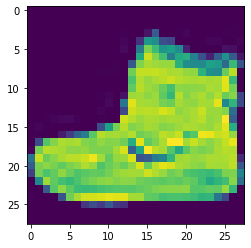

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze().numpy())
plt.show()

OK, that kinda sorta looks like a shoe? FashionMNIST is basically a bunch of black-white thumbnail images of different pieces of clothing. Let's try and plot a few of them. To step through the dataset, it will be helpful to construct a *data loader* object; we will use this while training our model below as well.

In [ ]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

Let's now use the DataLoader object to spit out a few images from the dataset.

64


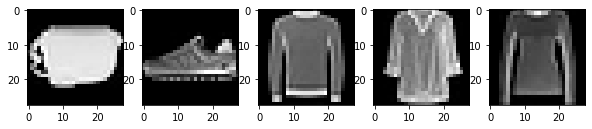

In [ ]:
images, labels = iter(trainDataLoader).next()
print(labels.shape[0])
plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.imshow(images[index].squeeze().numpy(),cmap=plt.cm.gray)

OK! Time to set up our model.

In the initialization function, we build up 3 hidden layers with 256, 128 ,64 neurons respectively and 1 output layer with input size 64, output size 10.

In [ ]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.hidden_layer1 = torch.nn.Linear(28*28,256)
    self.hidden_layer2 = torch.nn.Linear(256,128)
    self.hidden_layer3 = torch.nn.Linear(128,64)
    self.output_layer = torch.nn.Linear(64,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = torch.nn.functional.relu(self.hidden_layer1(x))
    transformed_x = torch.nn.functional.relu(self.hidden_layer2(transformed_x))
    transformed_x = torch.nn.functional.relu(self.hidden_layer3(transformed_x))
    transformed_x = self.output_layer(transformed_x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

Cool! Everything is set up. Let's now train our network.

In [ ]:
train_loss_history = []
test_loss_history = []
matchSample = 0
total = 0

for epoch in range(60):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader): # every time we use trainDataLoader, it will read 64 sample from 60000 samples
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
      predicted = torch.max(predicted_output.data,1)[1]
      matchSample += (predicted == labels).sum().item()
      total += labels.shape[0]
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 1.8291424095376467, Test loss 1.0742837338690545
Epoch 1, Train loss 0.8578743217215101, Test loss 0.7557273949407468
Epoch 2, Train loss 0.6829571581598538, Test loss 0.6487537109927767
Epoch 3, Train loss 0.5985138725433776, Test loss 0.5907559206910954
Epoch 4, Train loss 0.5469908123490399, Test loss 0.5909633285300747
Epoch 5, Train loss 0.513526411993163, Test loss 0.5588198158012074
Epoch 6, Train loss 0.4884722268562327, Test loss 0.5192150794396735
Epoch 7, Train loss 0.46828202877852965, Test loss 0.48984338827193924
Epoch 8, Train loss 0.45231327258828863, Test loss 0.4736497064304959
Epoch 9, Train loss 0.4384900077955047, Test loss 0.4851857104878517
Epoch 10, Train loss 0.4276218363629984, Test loss 0.45991426981558464
Epoch 11, Train loss 0.4160708460980641, Test loss 0.44607398008844656
Epoch 12, Train loss 0.4071153639666816, Test loss 0.47497020206254
Epoch 13, Train loss 0.39842337836970143, Test loss 0.43033252333759503
Epoch 14, Train loss 0.389

Let's see how we did! We have tracked the losses so let's plot it.

accuracy: 85.00866666666667


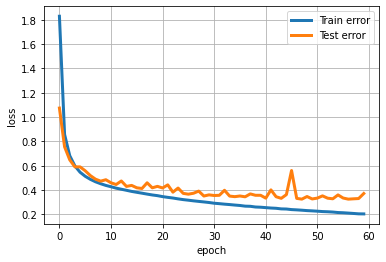

In [ ]:
plt.plot(range(60),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(60),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
acc = 100.0 * matchSample / total
print("accuracy:",acc)

We can see that first plot is a shoe, the second is a cloth, the last one is a trousers from the first row.

As we see in the second row. The first graph is most likely belongs to label 10, the second graph is most likely belongs to label 3, the last graph is most likely belongs to label 2

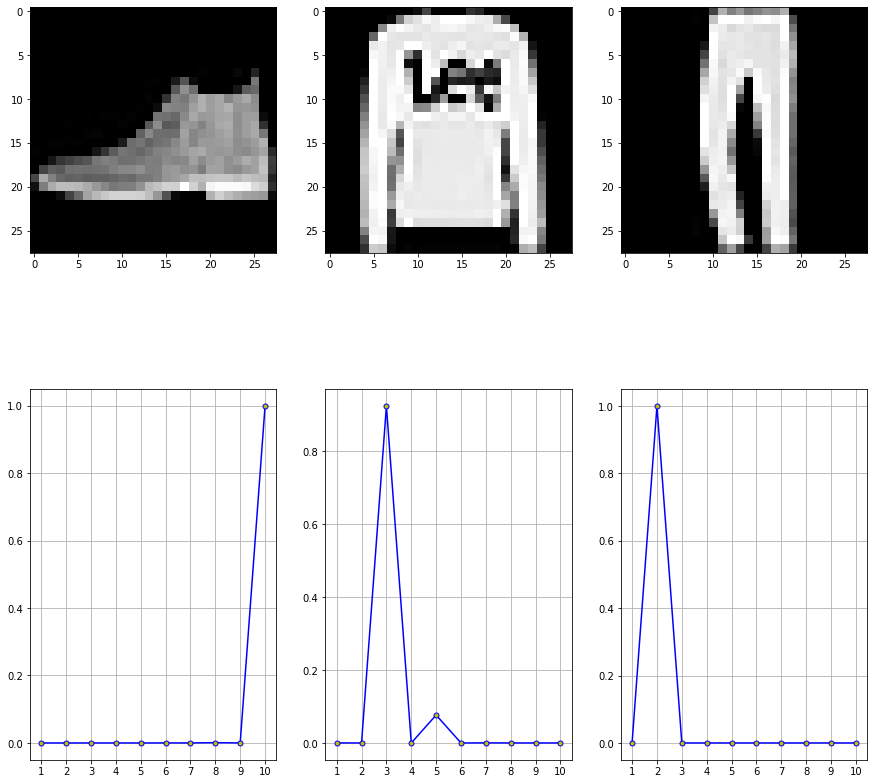

In [ ]:
from pylab import xticks,yticks
plt.figure(figsize=(15,15))
for index in np.arange(0,3):
  image = testdata[index][0]
  image = image.cuda()
  plt.subplot(2,3,index+1)
  plt.imshow(image.cpu().squeeze().numpy(),cmap=plt.cm.gray)
  predicted_output = net(image)
  softmax_output = torch.nn.functional.softmax(predicted_output,1)
  # print(softmax_output)
  # print(predicted_output)
  plt.subplot(2,3,index+4)
  xticks(np.linspace(1,10,10,endpoint=True))
  plt.ylim = [0,1]
  plt.xlabel = 'class'
  plt.ylabel = 'prob'
  x = np.linspace(1,10,10)
  y = softmax_output.cpu().squeeze().detach().numpy()
  # print(softmax_output.cpu().squeeze().detach().numpy())
  plt.plot(x,y,label = 'prob distribution',color = 'b',marker='o',markerfacecolor='y',markersize=5)
  # for i,j in zip(x,y):
  #   if j == 0:continue
  #   plt.text(i,j,j,ha='center',va='bottom',fontsize=15)
  plt.grid()
